# Í∏∞Î≥∏ ÏÑ§Ï†ï

In [2]:
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

# Í∏∞Î≥∏ ÎùºÏù¥Î∏åÎü¨Î¶¨
import os
import json
import shutil

# PyTorch Í¥ÄÎ†® ÎùºÏù¥Î∏åÎü¨Î¶¨
import torch.utils.data as data
import torch.backends.cudnn as cudnn

# Ïù¥ÎØ∏ÏßÄ Î≥ÄÌôò Í¥ÄÎ†® ÎùºÏù¥Î∏åÎü¨Î¶¨
from torchvision import transforms

# Îç∞Ïù¥ÌÑ∞ Î°úÎçî Î∞è Î™®Îç∏, Ïú†Ìã∏Î¶¨Ìã∞ Ìï®Ïàò Î∂àÎü¨Ïò§Í∏∞
from data_loader import get_segmentation_dataset  # Îç∞Ïù¥ÌÑ∞ÏÖã Î∂àÎü¨Ïò§Îäî Ìï®Ïàò
from utils.loss import MixSoftmaxCrossEntropyLoss, MixSoftmaxCrossEntropyOHEMLoss  # ÏÜêÏã§ Ìï®Ïàò
from utils.lr_scheduler import LRScheduler  # ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨
from utils.metric import SegmentationMetric  # ÌèâÍ∞Ä ÏßÄÌëú

from modules import conv3x3, conv1x1, DWConvBNAct, PWConvBNAct, ConvBNAct, Activation, SegHead
from model_registry import register_model, aux_models

# Python Î™®Îìà Í≤ΩÎ°úÏóê 'models' Ìè¥Îçî Ï∂îÍ∞Ä
models_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/models"

if models_path not in sys.path:
    sys.path.append(models_path)  # models Ìè¥Îçî Ï∂îÍ∞Ä
    
# sys.path ÌôïÏù∏ (Ï†úÎåÄÎ°ú Ï∂îÍ∞ÄÎêòÏóàÎäîÏßÄ)
print("Python Í≤ΩÎ°ú Î™©Î°ù:")
print("\n".join(sys.path))

train_img_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/train"
dataset_root = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets"

Python Í≤ΩÎ°ú Î™©Î°ù:
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python39.zip
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/lib-dynload

/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages/IPython/extensions
/home/segmentsafestep/.ipython
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages/setuptools/_vendor
/home/segmentsafestep/Fast-SCNN-pytorch-master/models


In [2]:
import torch

# GPUÍ∞Ä Í∞ÄÎä•ÌïòÎ©¥ ÏÇ¨Ïö©ÌïòÍ≥†, ÏïÑÎãàÎ©¥ CPU ÏÇ¨Ïö©
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("ÌòÑÏû¨ ÏÇ¨Ïö© Ï§ëÏù∏ ÎîîÎ∞îÏù¥Ïä§:", device)
if torch.cuda.is_available():
    print("ÏÇ¨Ïö© Ï§ëÏù∏ GPU:", torch.cuda.get_device_name(0))

ÌòÑÏû¨ ÏÇ¨Ïö© Ï§ëÏù∏ ÎîîÎ∞îÏù¥Ïä§: cuda
ÏÇ¨Ïö© Ï§ëÏù∏ GPU: NVIDIA L4


# Î™®Îç∏ ÏÑ§Ï†ï

In [3]:
# BiSeNetV2 Î™®Îç∏ Ï†ïÏùò
@register_model(aux_models)  # Î™®Îç∏ÏùÑ Îì±Î°ùÌïòÎäî Decorator (ÏÇ¨Ïö©Ïûê Ï†ïÏùò Î™®Îç∏ Îì±Î°ùÏùÑ ÏúÑÌïú ÏΩîÎìú)
class BiSeNetv2(nn.Module):
    def __init__(self, num_class=1, n_channel=3, act_type='relu', use_aux=True):
        super().__init__()
        self.use_aux = use_aux  # Î≥¥Ï°∞ Î∂ÑÎ•ò(head) ÏÇ¨Ïö© Ïó¨Î∂Ä ÏÑ§Ï†ï (TrueÏùº Í≤ΩÏö∞ Î≥¥Ï°∞ Ï∂úÎ†• ÏÇ¨Ïö©)

        # ÏÉÅÏÑ∏Ìïú ÌäπÏßïÏùÑ Ï∂îÏ∂úÌïòÎäî Branch
        self.detail_branch = DetailBranch(n_channel, 128, act_type)

        # ÏùòÎØ∏Î°†Ï†Å ÌäπÏßï(Semantic Feature)ÏùÑ Ï∂îÏ∂úÌïòÎäî Branch
        self.semantic_branch = SemanticBranch(n_channel, 128, num_class, act_type, use_aux)

        # Îëê Í∞úÏùò BranchÏóêÏÑú ÎÇòÏò® ÌäπÏßïÏùÑ Ìï©ÏπòÎäî Layer
        self.bga_layer = BilateralGuidedAggregationLayer(128, 128, act_type)

        # ÏµúÏ¢Ö Segmentation Í≤∞Í≥ºÎ•º Ï∂úÎ†•ÌïòÎäî Segmentation Head
        self.seg_head = SegHead(128, num_class, act_type)

    def forward(self, x, is_training=False):
        size = x.size()[2:]  # ÏõêÎ≥∏ ÏûÖÎ†• ÌÅ¨Í∏∞ Ï†ÄÏû• (ÏóÖÏÉòÌîåÎßÅÏóê ÏÇ¨Ïö©)
        x_d = self.detail_branch(x)  # Detail Branch Ïã§Ìñâ (ÎØ∏ÏÑ∏Ìïú ÌäπÏßï Ï∂îÏ∂ú)

        # Î≥¥Ï°∞ Î∂ÑÎ•ò ÏÇ¨Ïö© Ïó¨Î∂ÄÏóê Îî∞Îùº Ï≤òÎ¶¨ Î∞©Ïãù Í≤∞Ï†ï
        if self.use_aux:
            x_s, aux2, aux3, aux4, aux5 = self.semantic_branch(x)  # Semantic Branch Ïã§Ìñâ
        else:
            x_s = self.semantic_branch(x)

        x = self.bga_layer(x_d, x_s)  # Îëê Í∞úÏùò Branch Ï∂úÎ†• Ìï©ÏÑ±
        x = self.seg_head(x)  # ÏµúÏ¢Ö Segmentation Í≤∞Í≥º Ï∂úÎ†•
        x = F.interpolate(x, size, mode='bilinear', align_corners=True)  # ÏõêÎ≥∏ ÌÅ¨Í∏∞Î°ú ÏóÖÏÉòÌîåÎßÅ

        # Î≥¥Ï°∞ Î∂ÑÎ•ò ÏÇ¨Ïö© Ïó¨Î∂ÄÏóê Îî∞Îùº Ï∂îÍ∞Ä Î≥¥Ï°∞ Ï∂úÎ†• Î∞òÌôò
        if self.use_aux and is_training:
            return x, (aux2, aux3, aux4, aux5)
        else:
            return x
        
# Detail Branch: Í≥†Ìï¥ÏÉÅÎèÑ ÌäπÏßïÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú ÏÑ∏Î∂Ä Ï†ïÎ≥¥Î•º Ï∂îÏ∂ú
class DetailBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__(
            ConvBNAct(in_channels, 64, 3, 2, act_type=act_type),  # ÏûÖÎ†• Ï±ÑÎÑê ‚Üí 64 Ï±ÑÎÑê Î≥ÄÌôò, Îã§Ïö¥ÏÉòÌîåÎßÅ
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv Ïó∞ÏÇ∞ (ÌïÑÌÑ∞ Ïú†ÏßÄ)
            ConvBNAct(64, 64, 3, 2, act_type=act_type),  # Îã§Ïö¥ÏÉòÌîåÎßÅ
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv Ïó∞ÏÇ∞
            ConvBNAct(64, 128, 3, 1, act_type=act_type),  # Ï±ÑÎÑê ÌôïÏû•
            ConvBNAct(128, 128, 3, 2, act_type=act_type),  # Îã§Ïö¥ÏÉòÌîåÎßÅ
            ConvBNAct(128, 128, 3, 1, act_type=act_type),  # Conv Ïó∞ÏÇ∞
            ConvBNAct(128, out_channels, 3, 1, act_type=act_type)  # ÏµúÏ¢Ö Ï∂úÎ†•
        )
        
# Semantic Branch: Ï†ÄÌï¥ÏÉÅÎèÑ ÌäπÏßïÏùÑ Ï∂îÏ∂úÌïòÎ©¥ÏÑú ÏùòÎØ∏Î°†Ï†Å Ï†ïÎ≥¥Î•º ÌïôÏäµ
class SemanticBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_class, act_type='relu', use_aux=False):
        super().__init__()
        self.use_aux = use_aux  # Î≥¥Ï°∞ Ï∂úÎ†•ÏùÑ ÏÇ¨Ïö©Ìï†ÏßÄ Ïó¨Î∂Ä

        # Ï≤´ Î≤àÏß∏ Îã®Í≥Ñ: Ï¥àÍ∏∞ Feature Ï∂îÏ∂ú
        self.stage1to2 = StemBlock(in_channels, 16, act_type)

        # Îëê Î≤àÏß∏ Îã®Í≥Ñ: Ï†ÄÌï¥ÏÉÅÎèÑ ÌäπÏßï Ï∂îÏ∂ú
        self.stage3 = nn.Sequential(
            GatherExpansionLayer(16, 32, 2, act_type),  # Îã§Ïö¥ÏÉòÌîåÎßÅ (16 ‚Üí 32 Ï±ÑÎÑê)
            GatherExpansionLayer(32, 32, 1, act_type),  # Conv Ïó∞ÏÇ∞
        )

        self.stage4 = nn.Sequential(
            GatherExpansionLayer(32, 64, 2, act_type),  # Îã§Ïö¥ÏÉòÌîåÎßÅ (32 ‚Üí 64 Ï±ÑÎÑê)
            GatherExpansionLayer(64, 64, 1, act_type),  # Conv Ïó∞ÏÇ∞
        )

        self.stage5_1to4 = nn.Sequential(
            GatherExpansionLayer(64, 128, 2, act_type),  # Îã§Ïö¥ÏÉòÌîåÎßÅ (64 ‚Üí 128 Ï±ÑÎÑê)
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
        )

        self.stage5_5 = ContextEmbeddingBlock(128, out_channels, act_type)  # Í∏ÄÎ°úÎ≤å Ïª®ÌÖçÏä§Ìä∏ ÌïôÏäµ

        # Î≥¥Ï°∞ Î∂ÑÎ•òÍ∏∞ Ï†ïÏùò (auxiliary segmentation heads)
        if self.use_aux:
            self.seg_head2 = SegHead(16, num_class, act_type)
            self.seg_head3 = SegHead(32, num_class, act_type)
            self.seg_head4 = SegHead(64, num_class, act_type)
            self.seg_head5 = SegHead(128, num_class, act_type)

    def forward(self, x):
        x = self.stage1to2(x)
        if self.use_aux:
            aux2 = self.seg_head2(x)

        x = self.stage3(x)
        if self.use_aux:
            aux3 = self.seg_head3(x)

        x = self.stage4(x)
        if self.use_aux:
            aux4 = self.seg_head4(x)

        x = self.stage5_1to4(x)
        if self.use_aux:
            aux5 = self.seg_head5(x)

        x = self.stage5_5(x)  # ÏµúÏ¢Ö ÏùòÎØ∏Î°†Ï†Å Ï†ïÎ≥¥ Ï∂îÏ∂ú

        if self.use_aux:
            return x, aux2, aux3, aux4, aux5
        else:
            return x
        
class StemBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.conv_init = ConvBNAct(in_channels, out_channels, 3, 2, act_type=act_type)
        self.left_branch = nn.Sequential(
                            ConvBNAct(out_channels, out_channels//2, 1, act_type=act_type),
                            ConvBNAct(out_channels//2, out_channels, 3, 2, act_type=act_type)
                    )
        self.right_branch = nn.MaxPool2d(3, 2, 1)
        self.conv_last = ConvBNAct(out_channels*2, out_channels, 3, 1, act_type=act_type)

    def forward(self, x):
        x = self.conv_init(x)
        x_left = self.left_branch(x)
        x_right = self.right_branch(x)
        x = torch.cat([x_left, x_right], dim=1)
        x = self.conv_last(x)

        return x
    
class GatherExpansionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride, act_type='relu', expand_ratio=6,):
        super().__init__()
        self.stride = stride
        hid_channels = int(round(in_channels * expand_ratio))

        layers = [ConvBNAct(in_channels, in_channels, 3, act_type=act_type)]

        if stride == 2:
            layers.extend([
                            DWConvBNAct(in_channels, hid_channels, 3, 2, act_type='none'),
                            DWConvBNAct(hid_channels, hid_channels, 3, 1, act_type='none')
                        ])
            self.right_branch = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type='none'),
                                    PWConvBNAct(in_channels, out_channels, act_type='none')
                            )
        else:
            layers.append(DWConvBNAct(in_channels, hid_channels, 3, 1, act_type='none'))

        layers.append(PWConvBNAct(hid_channels, out_channels, act_type='none'))
        self.left_branch = nn.Sequential(*layers)
        self.act = Activation(act_type)

    def forward(self, x):
        res = self.left_branch(x)

        if self.stride == 2:
            res = self.right_branch(x) + res
        else:
            res = x + res

        return self.act(res)
    
class ContextEmbeddingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.pool = nn.Sequential(
                            nn.AdaptiveAvgPool2d(1),
                            nn.BatchNorm2d(in_channels)
                    )
        self.conv_mid = ConvBNAct(in_channels, in_channels, 1, act_type=act_type)
        self.conv_last = conv3x3(in_channels, out_channels)

    def forward(self, x):
        res = self.pool(x)
        res = self.conv_mid(res)
        x = res + x
        x = self.conv_last(x)

        return x
    
class BilateralGuidedAggregationLayer(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.detail_high = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels)
                        )
        self.detail_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type=act_type),
                                    nn.AvgPool2d(3, 2, 1)
                        )
        self.semantic_high = nn.Sequential(
                                    ConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True),
                                    nn.Sigmoid()
                            )
        self.semantic_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels),
                                    nn.Sigmoid()
                            )
        self.conv_last = ConvBNAct(in_channels, out_channels, 3, act_type=act_type)

    def forward(self, x_d, x_s):
        x_d_high = self.detail_high(x_d)
        x_d_low = self.detail_low(x_d)

        x_s_high = self.semantic_high(x_s)
        x_s_low = self.semantic_low(x_s)
        x_high = x_d_high * x_s_high
        x_low = x_d_low * x_s_low

        size = x_high.size()[2:]
        x_low = F.interpolate(x_low, size, mode='bilinear', align_corners=True)
        res = x_high + x_low
        res = self.conv_last(res)

        return res

In [4]:
# ÌÅ¥ÎûòÏä§ 22Í∞ú
model = BiSeNetv2(num_class=22)

# GPU ÏûêÎèô ÏÑ§Ï†ï
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Î™®Îç∏ÏùÑ GPU ÎòêÎäî CPUÎ°ú ÏòÆÍ∏∞Í∏∞
model = model.to(device)

## Í∞ÄÏ§ëÏπò ÌååÏùºÏóê Îã¥Í≤®ÏûàÎäî Ï†ïÎ≥¥ ÌôïÏù∏ÌïòÍ∏∞

In [6]:
"""
# Í∞ÄÏ§ëÏπò ÌååÏùº Í≤ΩÎ°ú
pth_file = "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/model_indobohaeng_10.pth"

# Í∞ÄÏ§ëÏπò ÌååÏùº Î°úÎìú
checkpoint = torch.load(pth_file, map_location="cpu")

# Í∞ÄÏ§ëÏπò ÌååÏùºÏóê Ï†ÄÏû•Îêú key Î™©Î°ù Ï∂úÎ†•
print("Í∞ÄÏ§ëÏπò ÌååÏùºÏóê Ìè¨Ìï®Îêú ÌÇ§ Î™©Î°ù:")
for key in checkpoint.keys():
    print(f"  - {key}")

# Î™®Îç∏ Í∞ÄÏ§ëÏπòÍ∞Ä Ï†ÄÏû•Îêú ÌÇ§Í∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
if "state_dict" in checkpoint:
    print("\n'state_dict' ÌÇ§Í∞Ä Ìè¨Ìï®Îê® (Î™®Îç∏ Í∞ÄÏ§ëÏπò Ìè¨Ìï®)")
    state_dict = checkpoint["state_dict"]

    # Í∞ÄÏ§ëÏπò Î†àÏù¥Ïñ¥ Ïù¥Î¶Ñ Ï∂úÎ†• (ÏµúÎåÄ 10Í∞úÎßå)
    print("\nÍ∞ÄÏ§ëÏπò Î†àÏù¥Ïñ¥ Î™©Î°ù:")
    for i, (name, param) in enumerate(state_dict.items()):
        if i < 10:  # 10Í∞úÍπåÏßÄÎßå Ï∂úÎ†•
            print(f"  - {name}: {param.shape}")
        else:
            print("  ... (Îçî ÎßéÏùÄ Í∞ÄÏ§ëÏπòÍ∞Ä ÏûàÏùå)")
            break
else:
    print("\n'state_dict' ÌÇ§Í∞Ä ÏóÜÏùå (Î™®Îç∏ Í∞ÄÏ§ëÏπòÍ∞Ä Ï†ÄÏû•ÎêòÏßÄ ÏïäÏùÄ ÌååÏùºÏùº Ïàò ÏûàÏùå)")

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌååÏùºÏóê Îã§Î•∏ Ï†ïÎ≥¥(Ïòà: ÌïôÏäµÎ•†, ÏóêÌè¨ÌÅ¨ Îì±)Í∞Ä Ï†ÄÏû•ÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
metadata_keys = [key for key in checkpoint.keys() if key != "state_dict"]
if metadata_keys:
    print("\nÏ∂îÍ∞ÄÏ†ÅÏù∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ìè¨Ìï®:")
    for key in metadata_keys:
        print(f"  - {key}: {checkpoint[key]}")
else:
    print("\nÏ∂îÍ∞ÄÏ†ÅÏù∏ ÌïôÏäµ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÏóÜÏùå (Í∞ÄÏ§ëÏπò Ï†ïÎ≥¥Îßå Ìè¨Ìï®Îê®)")

Í∞ÄÏ§ëÏπò ÌååÏùºÏóê Ìè¨Ìï®Îêú ÌÇ§ Î™©Î°ù:
  - epoch
  - state_dict

'state_dict' ÌÇ§Í∞Ä Ìè¨Ìï®Îê® (Î™®Îç∏ Í∞ÄÏ§ëÏπò Ìè¨Ìï®)

Í∞ÄÏ§ëÏπò Î†àÏù¥Ïñ¥ Î™©Î°ù:
  - detail_branch.0.0.weight: torch.Size([64, 3, 3, 3])
  - detail_branch.0.1.weight: torch.Size([64])
  - detail_branch.0.1.bias: torch.Size([64])
  - detail_branch.0.1.running_mean: torch.Size([64])
  - detail_branch.0.1.running_var: torch.Size([64])
  - detail_branch.0.1.num_batches_tracked: torch.Size([])
  - detail_branch.1.0.weight: torch.Size([64, 64, 3, 3])
  - detail_branch.1.1.weight: torch.Size([64])
  - detail_branch.1.1.bias: torch.Size([64])
  - detail_branch.1.1.running_mean: torch.Size([64])
  ... (Îçî ÎßéÏùÄ Í∞ÄÏ§ëÏπòÍ∞Ä ÏûàÏùå)

Ï∂îÍ∞ÄÏ†ÅÏù∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ìè¨Ìï®:
  - epoch: 10


In [5]:
print(model)  # Î™®Îç∏Ïù¥ Ï†ïÏÉÅÏ†ÅÏúºÎ°ú ÏÑ†Ïñ∏ÎêòÏóàÎäîÏßÄ ÌôïÏù∏

BiSeNetv2(
  (detail_branch): DetailBranch(
    (0): ConvBNAct(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (1): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (2): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (3): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

---

# ÌïôÏäµ

In [31]:
# Î™®Îç∏ Î∞è ÌïôÏäµ Í¥ÄÎ†® ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
args = {
    "model": "BiSeNetv2",  # ÏÇ¨Ïö©Ìï† Î™®Îç∏ Ïù¥Î¶Ñ
    "dataset": "surface",  # ÌïôÏäµÌï† Îç∞Ïù¥ÌÑ∞ÏÖã (Ïòà: Cityscapes)
    "base_size": 1024,  # ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ Í∏∞Î≥∏ ÌÅ¨Í∏∞
    "crop_size": 768,  # ÌïôÏäµ Ïãú ÏÇ¨Ïö©Ìï† ÌÅ¨Î°≠ ÌÅ¨Í∏∞
    "train_split": "train",  # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Î∂ÑÌï† Î∞©Ïãù

    # ÌïôÏäµ ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
    "aux": False,  # Î≥¥Ï°∞ ÏÜêÏã§ ÏÇ¨Ïö© Ïó¨Î∂Ä
    "aux_weight": 0.4,  # Î≥¥Ï°∞ ÏÜêÏã§ Í∞ÄÏ§ëÏπò
    "epochs": 50,  # ÌïôÏäµ ÏóêÌè≠ Ïàò
    "start_epoch": 0,  # ÌïôÏäµ ÏãúÏûë ÏóêÌè≠
    "batch_size": 8,  # Î∞∞Ïπò ÌÅ¨Í∏∞Î•º Î∞îÍøà
    "lr": 1e-2,  # ÌïôÏäµÎ•†ÏùÑ Î∞îÍø®Ïñ¥. Îçî ÌÅ¨Í≤å ÌïôÏäµ ÎèåÎ†§Î≥¥Î©¥ÏÑú ÌôïÏù∏Ìï¥Î¥ê
    "momentum": 0.9,  # Î™®Î©òÌÖÄ
    "weight_decay": 1e-4,  # Í∞ÄÏ§ëÏπò Í∞êÏá† (L2 Ï†ïÍ∑úÌôî)

    # Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Ï†ÄÏû• ÏúÑÏπò
    "resume": True,  # Í∏∞Ï°¥ Î™®Îç∏ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ (ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏùå)
    "save_folder": "./weights",  # Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû• Í≤ΩÎ°ú

    # ÌèâÍ∞Ä Î∞è Í≤ÄÏ¶ù ÏÑ§Ï†ï
    "eval": False,  # ÌèâÍ∞Ä Î™®Îìú Ïó¨Î∂Ä
    "no_val": True,  # Í≤ÄÏ¶ù ÏÉùÎûµ Ïó¨Î∂Ä
}

# GPU ÏÇ¨Ïö© Ïó¨Î∂Ä ÏÑ§Ï†ï
print(device := torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
cudnn.benchmark = True  # GPU Ïó∞ÏÇ∞ ÏµúÏ†ÅÌôî
args["device"] = device  # ÌïôÏäµÏóê ÏÇ¨Ïö©Ìï† ÎîîÎ∞îÏù¥Ïä§ Ï†ÄÏû•

cuda:0


In [32]:
# Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ Î≥ÄÌôò ÏÑ§Ï†ï
input_transform = transforms.Compose([
    transforms.ToTensor(),  # Ïù¥ÎØ∏ÏßÄÎ•º TensorÎ°ú Î≥ÄÌôò
    transforms.Normalize([0.3257, 0.3690, 0.3223], [0.2112, 0.2148, 0.2115]),  # Ïù¥ÎØ∏ÏßÄ Ï†ïÍ∑úÌôî
])

# Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú (ÌïôÏäµ Î∞è Í≤ÄÏ¶ù)
data_kwargs = {"transform": input_transform, "base_size": args["base_size"], "crop_size": args["crop_size"]}
train_dataset = get_segmentation_dataset(args["dataset"], split=args["train_split"], mode="train", root=dataset_root, **data_kwargs)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="val", root=dataset_root, **data_kwargs)

# DataLoader ÏÉùÏÑ± (Îç∞Ïù¥ÌÑ∞ Î∞∞Ïπò Îã®ÏúÑÎ°ú Î°úÎî©)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=args["batch_size"], shuffle=True, num_workers=4 # Ïù¥Í±∞ ÏàòÏ†ïÌï¥Î¥ê
                               , drop_last=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

# Î™®Îç∏ÏùÑ GPU ÎòêÎäî CPUÎ°ú Ïù¥Îèô
dev_mod = model.to(args["device"])

cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045448.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045448.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045451.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045451.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045466.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045466.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045472.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel

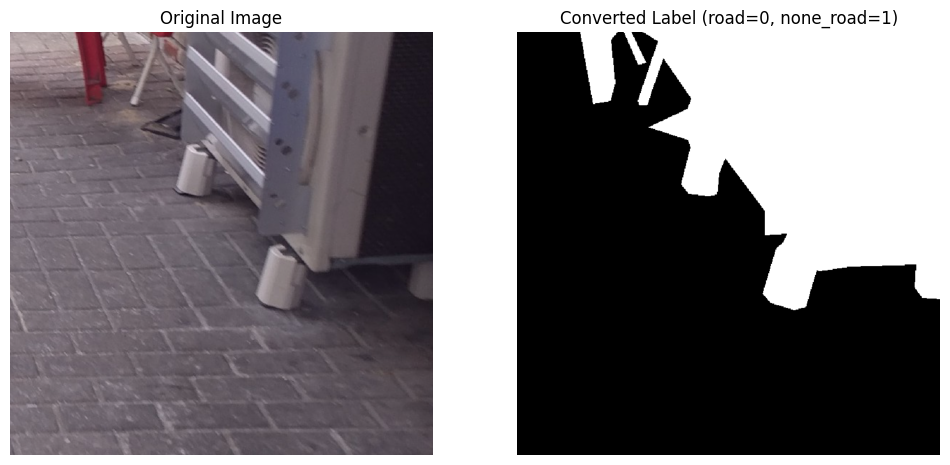

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Í∞ÄÏ†∏Ïò§Í∏∞
image, target = train_dataset[0]  # Ï≤´ Î≤àÏß∏ ÏÉòÌîå Îç∞Ïù¥ÌÑ∞

# ÌÖêÏÑúÎ•º NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò (CPUÎ°ú Ïù¥Îèô ÌõÑ Î≥ÄÌôò)
image_np = image.permute(1, 2, 0).cpu().numpy()  # [C, H, W] ‚Üí [H, W, C] Î≥ÄÌôò
image_np = (image_np * 0.2148) + 0.3690  # Ï†ïÍ∑úÌôî Ìï¥Ï†ú (ÌèâÍ∑† + ÌëúÏ§ÄÌé∏Ï∞® Í≥±ÌïòÍ∏∞)
image_np = np.clip(image_np, 0, 1)  # Í∞í Î≤îÏúÑ Ï°∞Ï†ï

target_np = target.cpu().numpy()  # ÎùºÎ≤® Îç∞Ïù¥ÌÑ∞ Î≥ÄÌôò

# ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ Î≥ÄÌôòÎêú ÎùºÎ≤®ÏùÑ ÎÇòÎûÄÌûà Ï∂úÎ†•
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÌëúÏãú
axes[0].imshow(image_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Î≥ÄÌôòÎêú ÎùºÎ≤® ÌëúÏãú
axes[1].imshow(target_np, cmap="gray")  # 0(Í≤ÄÏùÄÏÉâ), 1(Ìù∞ÏÉâ)
axes[1].set_title("Converted Label (road=0, none_road=1)")
axes[1].axis("off")

plt.show()

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏

In [34]:
# ÏÜêÏã§ Ìï®Ïàò ÏÑ§Ï†ï (OHEM Loss ÏÇ¨Ïö©)
criterion = MixSoftmaxCrossEntropyLoss(aux=args["aux"], aux_weight=args["aux_weight"], ignore_label=-1).to(args["device"])

# ÏòµÌã∞ÎßàÏù¥Ï†Ä (SGD ÏÇ¨Ïö©)
optimizer = torch.optim.SGD(model.parameters(), lr=args["lr"], momentum=args["momentum"], weight_decay=args["weight_decay"])

# ÌïôÏäµÎ•† Ïä§ÏºÄÏ§ÑÎü¨ ÏÑ§Ï†ï (poly decay ÏÇ¨Ïö©)
lr_scheduler = LRScheduler(mode="poly", base_lr=args["lr"], nepochs=args["epochs"],
                           iters_per_epoch=len(train_loader), power=0.9)

# ÌèâÍ∞Ä ÏßÄÌëú (mIoU Îì±)
metric = SegmentationMetric(train_dataset.num_class)

# ÏµúÍ≥† ÏÑ±Îä• Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î≥ÄÏàò
best_pred = 0.0

In [35]:
def train():
    global best_pred  # ÏµúÍ≥† ÏÑ±Îä• ÎπÑÍµêÎ•º ÏúÑÌïú Ï†ÑÏó≠ Î≥ÄÏàò ÏÇ¨Ïö©
    cur_iters = 0  # ÌòÑÏû¨ Î∞òÎ≥µ ÌöüÏàò
    start_time = time.time()  # ÌïôÏäµ ÏãúÏûë ÏãúÍ∞Ñ

    # Ï†ÄÏû•Ìï† Ìè¥Îçî ÏÉùÏÑ± (ÏóÜÏúºÎ©¥ ÏÉàÎ°ú ÎßåÎì¶)
    os.makedirs(args["save_folder"], exist_ok=True)

    # ÌûàÏä§ÌÜ†Î¶¨ Ï†ÄÏû•Ïö© ÎîïÏÖîÎÑàÎ¶¨ Ï¥àÍ∏∞Ìôî
    history = {"epoch": [], "loss": [], "lr": []}

    chk_pnt_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/model_indobohaeng_why29.pth"
    start_epoch = 0  # Í∏∞Î≥∏Í∞í

    if os.path.exists(chk_pnt_path):
        print(f"üîÅ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ {chk_pnt_path} Î∂àÎü¨Ïò§Îäî Ï§ë...")
        checkpoint = torch.load(chk_pnt_path, map_location=args["device"])
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"‚úÖ {start_epoch} ÏóêÌè≠Î∂ÄÌÑ∞ Ïù¥Ïñ¥ÏÑú ÌïôÏäµÏùÑ ÏãúÏûëÌï©ÎãàÎã§.")
    else:
        print("üö® Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏Í∞Ä Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§. Ï≤òÏùåÎ∂ÄÌÑ∞ ÌïôÏäµÏùÑ ÏãúÏûëÌï©ÎãàÎã§.")

    for epoch in range(start_epoch, args["epochs"]):
        model.train()
        start_time = time.time()

        epoch_loss = 0.0

        for i, (images, targets) in enumerate(train_loader):
            cur_lr = lr_scheduler(cur_iters)  # ÌòÑÏû¨ ÌïôÏäµÎ•† ÏÑ§Ï†ï
            for param_group in optimizer.param_groups:
                param_group["lr"] = cur_lr  # ÏòµÌã∞ÎßàÏù¥Ï†ÄÏóê ÌïôÏäµÎ•† Ï†ÅÏö©

            # Îç∞Ïù¥ÌÑ∞Î•º GPU/CPUÎ°ú Ïù¥Îèô
            images, targets = images.to(args["device"]), targets.to(args["device"])

            # Î™®Îç∏ ÏòàÏ∏° Î∞è ÏÜêÏã§ Í≥ÑÏÇ∞
            outputs = model(images)
            loss = criterion((outputs,), targets)

            # Ïó≠Ï†ÑÌåå Î∞è ÏµúÏ†ÅÌôî ÏàòÌñâ
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # ÏÜêÏã§ ÎàÑÏ†Å
            cur_iters += 1  # Î∞òÎ≥µ ÌöüÏàò Ï¶ùÍ∞Ä
            if cur_iters % 300 == 0:  # 100ÌöåÎßàÎã§ Î°úÍ∑∏ Ï∂úÎ†•
                print(f"Epoch [{epoch}/{args['epochs']}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

        end_time = time.time()  # ÏóêÌè≠ Ï¢ÖÎ£å ÏãúÍ∞Ñ Í∏∞Î°ù
        epoch_time = end_time - start_time  # ÏÜåÏöî ÏãúÍ∞Ñ Í≥ÑÏÇ∞
        print(f"Epoch {epoch} ÏôÑÎ£å! ÏÜåÏöî ÏãúÍ∞Ñ: {epoch_time:.2f} Ï¥à")

        # ÌûàÏä§ÌÜ†Î¶¨ Ï†ÄÏû•
        avg_loss = epoch_loss / len(train_loader)
        history["epoch"].append(epoch)
        history["loss"].append(avg_loss)
        history["lr"].append(cur_lr)

        # 5Ïùò Î∞∞Ïàò ÏóêÌè≠Ïùº ÎïåÎßå Ï†ÄÏû•
        # if epoch % 5 == 0:
        save_path = os.path.join(args["save_folder"], f"model_indobohaeng_lr{epoch}.pth")
        torch.save({"epoch": epoch, "state_dict": model.state_dict(), 
                    "optimizer": optimizer.state_dict(), "loss": avg_loss}, save_path)
        print(f"Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû•Îê®: {save_path}")

        # Í≤ÄÏ¶ù ÏàòÌñâ
        if not args["no_val"] and epoch % 5 == 0:
            validation(epoch)

    # ÌïôÏäµ ÌûàÏä§ÌÜ†Î¶¨ Ï†ÄÏû•
    history_path = os.path.join(args["save_folder"], "train_history_smpl_city30.json")
    with open(history_path, "w") as f:
        json.dump(history, f)
    print(f"ÌïôÏäµ ÌûàÏä§ÌÜ†Î¶¨ Ï†ÄÏû• ÏôÑÎ£å: {history_path}")

In [36]:
def validation(epoch):
    global best_pred
    model.eval()
    metric.reset()

    import time
    val_start_time = time.time()  # Í≤ÄÏ¶ù ÏãúÏûë ÏãúÍ∞Ñ

    for i, (image, target) in enumerate(val_loader):
        image = image.to(args["device"])
        with torch.no_grad():
            outputs = (model(image),)

        pred = torch.argmax(outputs[0], 1).cpu().data.numpy()
        metric.update(pred, target.numpy())

    pixAcc, mIoU = metric.get()
    print(f"Epoch {epoch}, Validation Pixel Acc: {pixAcc:.3f}, mIoU: {mIoU:.3f}")

    new_pred = (pixAcc + mIoU) / 2
    if new_pred > best_pred:
        best_pred = new_pred

    val_end_time = time.time()
    val_duration = val_end_time - val_start_time  # Í≤ÄÏ¶ù ÏÜåÏöî ÏãúÍ∞Ñ
    print(f" - Í≤ÄÏ¶ù ÏÜåÏöî ÏãúÍ∞Ñ: {val_duration:.2f} Ï¥à")

    return mIoU

In [ ]:
train()

üîÅ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ /home/segmentsafestep/Fast-SCNN-pytorch-master/weights/model_indobohaeng_why29.pth Î∂àÎü¨Ïò§Îäî Ï§ë...
‚úÖ 30 ÏóêÌè≠Î∂ÄÌÑ∞ Ïù¥Ïñ¥ÏÑú ÌïôÏäµÏùÑ ÏãúÏûëÌï©ÎãàÎã§.
Epoch [30/50], Step [299/2882], Loss: 0.3737
Epoch [30/50], Step [599/2882], Loss: 0.1226
Epoch [30/50], Step [899/2882], Loss: 0.5440
Epoch [30/50], Step [1199/2882], Loss: 0.2182
Epoch [30/50], Step [1499/2882], Loss: 0.5770
Epoch [30/50], Step [1799/2882], Loss: 0.2909
Epoch [30/50], Step [2099/2882], Loss: 0.3153
Epoch [30/50], Step [2399/2882], Loss: 0.3373
Epoch [30/50], Step [2699/2882], Loss: 0.6137
Epoch 30 ÏôÑÎ£å! ÏÜåÏöî ÏãúÍ∞Ñ: 3882.23 Ï¥à
Î™®Îç∏ Í∞ÄÏ§ëÏπò Ï†ÄÏû•Îê®: ./weights/model_indobohaeng_lr30.pth
Epoch [31/50], Step [117/2882], Loss: 0.8065
Epoch [31/50], Step [417/2882], Loss: 0.3440
Epoch [31/50], Step [717/2882], Loss: 0.3824
Epoch [31/50], Step [1017/2882], Loss: 0.2134
Epoch [31/50], Step [1317/2882], Loss: 0.1407


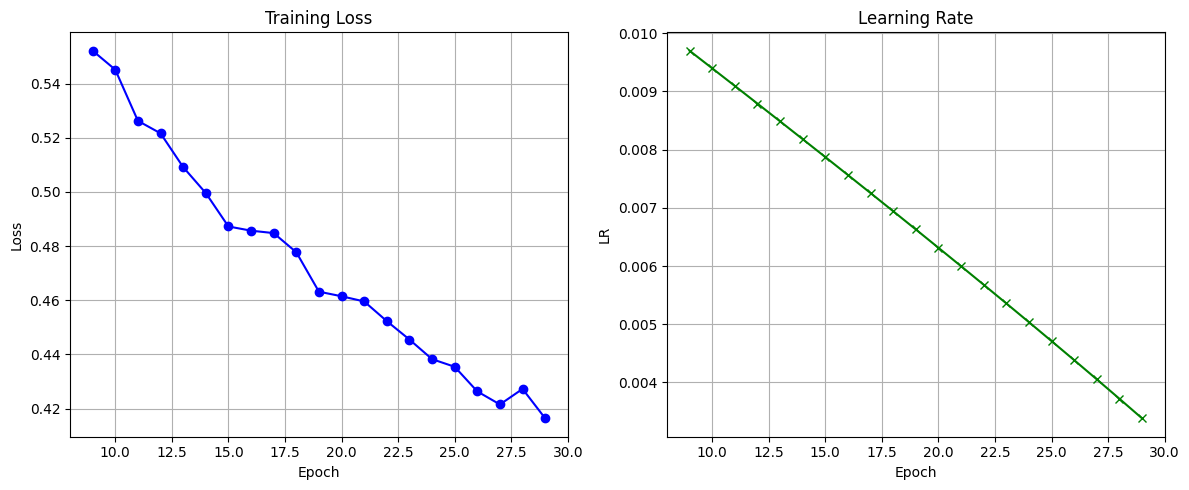

In [1]:
import json
import matplotlib.pyplot as plt

# Í≤ΩÎ°ú
history_path = "./weights/train_history_smpl_city.json"

# ÌååÏùº Î°úÎìú
with open(history_path, "r") as f:
    history = json.load(f)

epochs = history["epoch"]
losses = history["loss"]
lrs = history["lr"]

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
plt.figure(figsize=(12, 5))

# Loss Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Learning Rate Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 2)
plt.plot(epochs, lrs, marker='x', color='green')
plt.title("Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)

plt.tight_layout()
plt.show()

Í≤∞Í≥ºÎ•º Î≥¥ÎãàÍπå Í≤ÄÏ¶ùÏóê ÏãúÍ∞ÑÏù¥ ÏïΩ 4ÏãúÍ∞ÑÏù¥ Í±∏Î¶¨Í≥† 1ÏóêÌè≠ÎßàÎã§ 1ÏãúÍ∞Ñ Ï†ïÎèÑ Í±∏Î¶∞ Ïù¥ÌõÑ ÌååÏù∏ÌäúÎãù ÌòπÏùÄ Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌïôÏäµÏùÑ Ìï†ÎïåÎäî Í≤ÄÏ¶ùÏùÑ ÎπºÍ≥† Îß§Î≤à Í∞ÄÏ§ëÏπò ÌååÏùº Ï†ÄÏû•ÌïòÍ≤å ÏÑ§Ï†ïÌïòÍ≥† ÌïôÏäµ ÎèåÎ†§ÏïºÍ≤†Îã§.

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ Î∂àÎü¨Ïò§Í∏∞ (resume=TrueÏùº Îïå)
    if args["resume"]:
        if os.path.exists(chk_pnt_path):  # Í∞ÄÏ§ëÏπò ÌååÏùºÏù¥ ÏûàÎäîÏßÄ ÌôïÏù∏
            print(f"Ïù¥Ï†Ñ ÌïôÏäµ Í∞ÄÏ§ëÏπò Î∂àÎü¨Ïò§Îäî Ï§ë: {chk_pnt_path}")
            checkpoint = torch.load(chk_pnt_path, map_location=args["device"])
            model.load_state_dict(checkpoint["state_dict"])  # Î™®Îç∏ Í∞ÄÏ§ëÏπò Î°úÎìú
            checkpoint_state = {
                k: v for k, v in checkpoint["state_dict"].items()
                if not k.startswith("seg_head") and not k.startswith("semantic_branch.seg_head")
            }

            # ÌôïÏù∏Ïö© Î°úÍ∑∏
            # print(f"[Check] Î∂àÎü¨Ïò® checkpoint epoch: {checkpoint.get('epoch', 'Ï†ïÎ≥¥ ÏóÜÏùå')}")
            # print(f"[Check] Î∂àÎü¨Ïò® state_dict ÌååÎùºÎØ∏ÌÑ∞ Ïàò: {len(checkpoint_state)}Í∞ú")
            # first_key = list(checkpoint_state.keys())[0]
            # print(f"[Check] Ï≤´ Î≤àÏß∏ Î†àÏù¥Ïñ¥ ÌÇ§: {first_key}")
            # print(f"[Check] Ìï¥Îãπ ÌååÎùºÎØ∏ÌÑ∞ ÏùºÎ∂Ä Í∞í: {checkpoint_state[first_key].view(-1)[:5]}")

            start_epoch = checkpoint.get("epoch", -1) + 1
            print(f"ÌïôÏäµÏùÑ {start_epoch}Î≤àÏß∏ ÏóêÌè¨ÌÅ¨Î∂ÄÌÑ∞ Ïù¥Ïñ¥ÏÑú ÏßÑÌñâÌï©ÎãàÎã§.")
        else:
            print("ÏßÄÏ†ïÎêú Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. Ï≤òÏùåÎ∂ÄÌÑ∞ ÌïôÏäµÏùÑ ÏãúÏûëÌï©ÎãàÎã§.")
            start_epoch = args["start_epoch"]
    else:
        start_epoch = args["start_epoch"]

In [19]:
for i, (image, target) in enumerate(val_loader):
    image = image.to(args["device"])
    
    model.eval()  # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï (BatchNorm Î¨∏Ï†ú Ìï¥Í≤∞)

    with torch.no_grad():
        output = model(image)  # Î¶¨Ïä§Ìä∏Ïóê Ï†ÄÏû•ÌïòÏßÄ ÏïäÍ≥† Î∞îÎ°ú ÏÇ¨Ïö©
        output = output.argmax(dim=1).cpu().numpy()  # ÌïÑÏöîÌïòÎ©¥ Î∞îÎ°ú NumPyÎ°ú Î≥ÄÌôò

In [20]:
out = outputs[0][0]

# out = F.interpolate(out, size=org_size, align_corners=False, mode='bilinear')
print(out.shape)
out = out.argmax(dim=1)
print(out.shape)

# visualize
out = out.squeeze().detach().cpu().numpy()
pred = palette[out] # ÏïûÏÑú Ïª¨Îü¨ ÌåîÎ†àÌä∏Îäî ÎûúÎç§ÏúºÎ°ú ÏÑ∏ÌåÖ


NameError: name 'outputs' is not defined

In [21]:
import matplotlib.pyplot as plt

plt.imshow(pred)  # ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò Í≤∞Í≥º Ïù¥ÎØ∏ÏßÄ Ï∂úÎ†•
plt.axis("off")  # Ï∂ï Ï†úÍ±∞ (ÏÑ†ÌÉù ÏÇ¨Ìï≠)
plt.show()

NameError: name 'pred' is not defined

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ÏòàÏ∏°Îêú Í≤∞Í≥ºÎ•º Ï†ïÏàò ÌÅ¥ÎûòÏä§ IDÎ°ú Î≥ÄÌôò
out = outputs[0][0].argmax(dim=1).cpu().numpy()

# ÏòàÏ∏°Îêú ÌÅ¥ÎûòÏä§ ID Ï§ë Ïã§Ï†úÎ°ú Îì±Ïû•Ìïú ÌÅ¥ÎûòÏä§ Ï∞æÍ∏∞
unique_class_ids = np.unique(out)  # ÏòàÏ∏°Îêú ÌÅ¥ÎûòÏä§ ID
detected_classes = [CITYSCAPES_CLASSES[i] for i in unique_class_ids]  # ÌÅ¥ÎûòÏä§ Ïù¥Î¶Ñ Îß§Ïπ≠

# ÌÅ¥ÎûòÏä§ IDÎ•º ÏÉâÏÉÅ ÌåîÎ†àÌä∏Î°ú Î≥ÄÌôò
pred = np.zeros((*out.shape, 3), dtype=np.uint8)  # RGB Ïù¥ÎØ∏ÏßÄ ÌòïÌÉú ÏÉùÏÑ±
for class_id in unique_class_ids:
    pred[out == class_id] = CITYSCAPES_COLORS[CITYSCAPES_CLASSES[class_id]]

# Î∂àÌïÑÏöîÌïú Ï∞®Ïõê Ï†úÍ±∞ (MatplotlibÏù¥ Ïò¨Î∞îÎ•¥Í≤å Ïù∏ÏãùÌïòÎèÑÎ°ù)
pred = np.squeeze(pred)  # (1, H, W, 3) ‚Üí (H, W, 3)ÏúºÎ°ú Î≥ÄÍ≤Ω

# ÏãúÍ∞ÅÌôî (ÌÅ¥ÎûòÏä§Î≥Ñ ÏÉâÏÉÅ Î≤îÎ°Ä Ï∂îÍ∞Ä)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ÌÅ¥ÎûòÏä§ Î≤îÎ°Ä Ï∂úÎ†•
axes[0].imshow(pred)  # ÏàòÏ†ïÎêú `pred`Î•º ÏÇ¨Ïö©
axes[0].set_title("Segmentation Result")
axes[0].axis("off")

# ÌÅ¥ÎûòÏä§Î≥Ñ ÏÉâÏÉÅ Î≤îÎ°Ä Ï∂îÍ∞Ä
patches = [mpatches.Patch(color=np.array(CITYSCAPES_COLORS[class_name]) / 255.0, label=class_name)
           for class_name in detected_classes]
axes[1].legend(handles=patches, loc="center", fontsize="small", title="Classes")
axes[1].axis("off")

plt.tight_layout()
plt.show()

NameError: name 'outputs' is not defined

---

# miou ÌôïÏù∏ÌïòÍ∏∞

In [15]:
# Í∏∞Î≥∏ ÎùºÏù¥Î∏åÎü¨Î¶¨
import os
import torch
import torch.utils.data as data
from data_loader import get_segmentation_dataset  # Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú Ìï®Ïàò
from utils.metric import SegmentationMetric  # ÌèâÍ∞Ä ÏßÄÌëú

In [22]:
# ÏÑ§Ï†ï (Jupyter Notebook ÌôòÍ≤ΩÏóê ÎßûÍ≤å Î≥ÄÍ≤Ω)
args = {
    "dataset": "citys",  # ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞ÏÖã (Cityscapes)
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # GPU/CPU ÏÑ§Ï†ï
    "batch_size": 1,  # ÌèâÍ∞Ä Ïãú Î∞∞Ïπò ÌÅ¨Í∏∞
    "num_workers": 0,  # DataLoaderÏùò worker Í∞úÏàò (Î©îÎ™®Î¶¨ Î¨∏Ï†ú Î∞©ÏßÄ ÏúÑÌï¥ 0ÏúºÎ°ú ÏÑ§Ï†ï)
    "weight_path": "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/model_2class_5.pth"  # Ï†ÄÏû•Îêú Í∞ÄÏ§ëÏπò Í≤ΩÎ°ú
}

In [23]:
# Í∞ÄÏ§ëÏπò ÌååÏùº ÌôïÏù∏
if not os.path.exists(args["weight_path"]):
    raise FileNotFoundError(f"Í∞ÄÏ§ëÏπò ÌååÏùºÏù¥ Ï°¥Ïû¨ÌïòÏßÄ ÏïäÏäµÎãàÎã§: {args['weight_path']}")

# Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤òÎ¶¨ ÏÑ§Ï†ï
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

In [24]:
# Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú (Cityscapes val set)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="testval", transform=input_transform, root="/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets")
val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=args["batch_size"],
    shuffle=False,
    num_workers=args["num_workers"]
)

# Î™®Îç∏ Î∞è Í∞ÄÏ§ëÏπò Î°úÎìú
# model = BiSeNetv2(num_class=val_dataset.num_class).to(args["device"])  # Î™®Îç∏ ÏÉùÏÑ±

# Ï†ÄÏû•Îêú Í∞ÄÏ§ëÏπò ÌååÏùº Î°úÎìú
checkpoint = torch.load(args["weight_path"], map_location=args["device"])

# Í∞ÄÏ§ëÏπò ÌååÏùºÏóê state_dictÍ∞Ä Ìè¨Ìï®ÎêòÏñ¥ ÏûàÏúºÎ©¥, Î™®Îç∏ Í∞ÄÏ§ëÏπòÎßå Ï∂îÏ∂úÌïòÏó¨ Î°úÎìú
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])  # state_dictÎßå Î°úÎìú
else:
    model.load_state_dict(checkpoint)  # Ïù¥ÎØ∏ ÏàúÏàòÌïú Í∞ÄÏ§ëÏπò ÌååÏùºÏù¥Î©¥ Í∑∏ÎåÄÎ°ú Î°úÎìú

model.eval()  # Î™®Îç∏ÏùÑ ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï
print("Î™®Îç∏ Î∞è Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å!")

# ÌèâÍ∞Ä ÏßÄÌëú ÏÑ§Ï†ï (mIoU Î∞è ÌîΩÏÖÄ Ï†ïÌôïÎèÑ)
metric = SegmentationMetric(val_dataset.num_class)

Found 500 images in /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/val
Î™®Îç∏ Î∞è Í∞ÄÏ§ëÏπò Î°úÎìú ÏôÑÎ£å!


In [25]:
# Í≤ÄÏ¶ù ÏàòÌñâ Î∞è mIoU Í≥ÑÏÇ∞
print("Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã ÌèâÍ∞Ä Ï§ë...")
with torch.no_grad():
    for i, (image, label) in enumerate(val_loader):
        image = image.to(args["device"])
        label = label.cpu().numpy().squeeze()  # GPU -> CPU ÌõÑ Î∂àÌïÑÏöîÌïú Ï∞®Ïõê Ï†úÍ±∞

        # Î™®Îç∏ ÏòàÏ∏° ÏàòÌñâ
        outputs = model(image)

        # Î™®Îç∏ Ï∂úÎ†•Ïù¥ (C, W)Î°ú ÏûòÎ™ª ÎÇòÏò§Îäî Í≤ΩÏö∞, Ïò¨Î∞îÎ•¥Í≤å Î≥ÄÌôò
        if len(outputs.shape) == 3:  # (C, H, W) ÌòïÌÉúÎùºÎ©¥ batch Ï∞®ÏõêÏù¥ ÏóÜÏùå -> Ï∂îÍ∞Ä
            outputs = outputs.unsqueeze(0)  # (1, C, H, W) ÌòïÌÉúÎ°ú Î≥ÄÌôò
        elif len(outputs.shape) == 2:  # (C, W) ÌòïÌÉúÎùºÎ©¥ Ï∞®Ïõê Ïû¨Î∞∞Ïó¥ ÌïÑÏöî
            outputs = outputs.view(1, outputs.shape[0], 1, outputs.shape[1])  # (1, C, 1, W)Î°ú Î≥ÄÌôò
        
        # ÏòàÏ∏° Í≤∞Í≥º Í≥ÑÏÇ∞
        pred = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # (H, W) ÌòïÌÉúÎ°ú Î≥ÄÌôò
        
        # ÌèâÍ∞Ä ÏßÄÌëú ÏóÖÎç∞Ïù¥Ìä∏
        metric.update(pred, label)

        # 10Í∞úÎßàÎã§ Ï§ëÍ∞Ñ Í≤∞Í≥º Ï∂úÎ†•
        if (i + 1) % 10 == 0:
            pixAcc, mIoU = metric.get()
            print(f"Sample {i+1}: Pixel Accuracy = {pixAcc * 100:.2f}%, mIoU = {mIoU * 100:.2f}%")

# ÏµúÏ¢Ö ÌèâÍ∞Ä Í≤∞Í≥º Ï∂úÎ†•
final_pixAcc, final_mIoU = metric.get()
print("\nÏµúÏ¢Ö ÌèâÍ∞Ä Í≤∞Í≥º")
print(f"Pixel Accuracy: {final_pixAcc * 100:.2f}%")
print(f"Mean IoU (mIoU): {final_mIoU * 100:.2f}%")

Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã ÌèâÍ∞Ä Ï§ë...
Sample 10: Pixel Accuracy = 40.09%, mIoU = 8.79%
Sample 20: Pixel Accuracy = 38.77%, mIoU = 8.36%
Sample 30: Pixel Accuracy = 38.20%, mIoU = 9.09%


KeyboardInterrupt: 

## Í∞ÄÏ§ëÏπò ÌååÏùºÏóê Îã¥Í≤®ÏûàÎäî Ï†ïÎ≥¥ ÌôïÏù∏ÌïòÍ∏∞

In [24]:
import torch

# Í∞ÄÏ§ëÏπò ÌååÏùº Í≤ΩÎ°ú
pth_file = "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth"

# Í∞ÄÏ§ëÏπò ÌååÏùº Î°úÎìú
checkpoint = torch.load(pth_file, map_location="cpu")

# Í∞ÄÏ§ëÏπò ÌååÏùºÏóê Ï†ÄÏû•Îêú key Î™©Î°ù Ï∂úÎ†•
print("Í∞ÄÏ§ëÏπò ÌååÏùºÏóê Ìè¨Ìï®Îêú ÌÇ§ Î™©Î°ù:")
for key in checkpoint.keys():
    print(f"  - {key}")

# Î™®Îç∏ Í∞ÄÏ§ëÏπòÍ∞Ä Ï†ÄÏû•Îêú ÌÇ§Í∞Ä ÏûàÎäîÏßÄ ÌôïÏù∏
if "state_dict" in checkpoint:
    print("\n'state_dict' ÌÇ§Í∞Ä Ìè¨Ìï®Îê® (Î™®Îç∏ Í∞ÄÏ§ëÏπò Ìè¨Ìï®)")
    state_dict = checkpoint["state_dict"]

    # Í∞ÄÏ§ëÏπò Î†àÏù¥Ïñ¥ Ïù¥Î¶Ñ Ï∂úÎ†• (ÏµúÎåÄ 10Í∞úÎßå)
    print("\nÍ∞ÄÏ§ëÏπò Î†àÏù¥Ïñ¥ Î™©Î°ù:")
    for i, (name, param) in enumerate(state_dict.items()):
        if i < 10:  # 10Í∞úÍπåÏßÄÎßå Ï∂úÎ†•
            print(f"  - {name}: {param.shape}")
        else:
            print("  ... (Îçî ÎßéÏùÄ Í∞ÄÏ§ëÏπòÍ∞Ä ÏûàÏùå)")
            break
else:
    print("\n'state_dict' ÌÇ§Í∞Ä ÏóÜÏùå (Î™®Îç∏ Í∞ÄÏ§ëÏπòÍ∞Ä Ï†ÄÏû•ÎêòÏßÄ ÏïäÏùÄ ÌååÏùºÏùº Ïàò ÏûàÏùå)")

# Ï≤¥ÌÅ¨Ìè¨Ïù∏Ìä∏ ÌååÏùºÏóê Îã§Î•∏ Ï†ïÎ≥¥(Ïòà: ÌïôÏäµÎ•†, ÏóêÌè¨ÌÅ¨ Îì±)Í∞Ä Ï†ÄÏû•ÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏
metadata_keys = [key for key in checkpoint.keys() if key != "state_dict"]
if metadata_keys:
    print("\nÏ∂îÍ∞ÄÏ†ÅÏù∏ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ Ìè¨Ìï®:")
    for key in metadata_keys:
        print(f"  - {key}: {checkpoint[key]}")
else:
    print("\nÏ∂îÍ∞ÄÏ†ÅÏù∏ ÌïôÏäµ Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ ÏóÜÏùå (Í∞ÄÏ§ëÏπò Ï†ïÎ≥¥Îßå Ìè¨Ìï®Îê®)")

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth'

# Ïù¥ÎØ∏ÏßÄ ÌÖåÏä§Ìä∏